## Linearizing the HSV$\rightarrow$RGBA$\rightarrow$HSV transformation

So a problem with the RGBA-HSV transform is that it is does not do a great job at inverting the naive HSV-RGBA. Given a hue, RGBA$\rightarrow$RGB$\rightarrow$HSV

In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import importlib 
import colorxform

import colour
from colour.plotting import (
    plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931,
    plot_RGB_chromaticities_in_chromaticity_diagram_CIE1976UCS,
    colour_style,
    override_style,
    artist
)
#This version uses the colour_science library https://colour.readthedocs.io/
# in jupyter notebook remove semicolon to get list of properties
#colour_style();

space = 'Best RGB'
colourspace = colour.RGB_COLOURSPACES[space]

print(f"using {colourspace.name}")
print(colourspace)
colour.set_domain_range_scale('1')
print(colour.get_domain_range_scale())
#dir(colourspace)

using Best RGB
Best RGB
--------

Primaries          : [[ 0.73519164  0.26480836]
                      [ 0.21533613  0.77415966]
                      [ 0.13012295  0.03483607]]
Whitepoint         : [ 0.3457  0.3585]
Whitepoint Name    : D50
Encoding CCTF      : functools.partial(<function gamma_function at 0x7f121d76ee50>, exponent=0.45454545454545453)
Decoding CCTF      : functools.partial(<function gamma_function at 0x7f121d76ee50>, exponent=2.2)
NPM                : [[ 0.6318944   0.20538793  0.12701335]
                      [ 0.22760177  0.73839465  0.03400357]
                      [ 0.          0.01001892  0.81508568]]
NPM -1             : [[ 1.75737181 -0.48538023 -0.25359913]
                      [-0.54199672  1.50475404  0.02168337]
                      [ 0.00666215 -0.01849623  1.22659836]]
Derived NPM        : [[ 0.6318944   0.20538793  0.12701335]
                      [ 0.22760177  0.73839465  0.03400357]
                      [ 0.          0.01001892  0.81508568]]
De

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

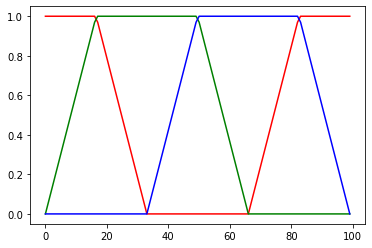

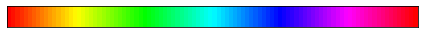

In [3]:
%matplotlib inline

# Generate RGB values for HSV spanning the hue range

HSV = [ [hue, 1.0, 1.0]  for hue in np.linspace(0., 1., num=100) ]
HSV = np.array(HSV)
gamut_RGB =  colour.HSV_to_RGB(HSV)

figure = plt.figure()
ax2 = figure.add_subplot()
ax2.plot(gamut_RGB[:,0],'r')
ax2.plot(gamut_RGB[:,1],'g')
ax2.plot(gamut_RGB[:,2],'b')


colour.plotting.plot_multi_colour_swatches(gamut_RGB, width=1.0, height=5.0, axis=ax2)
figure.savefig("RGB-HSV.png")

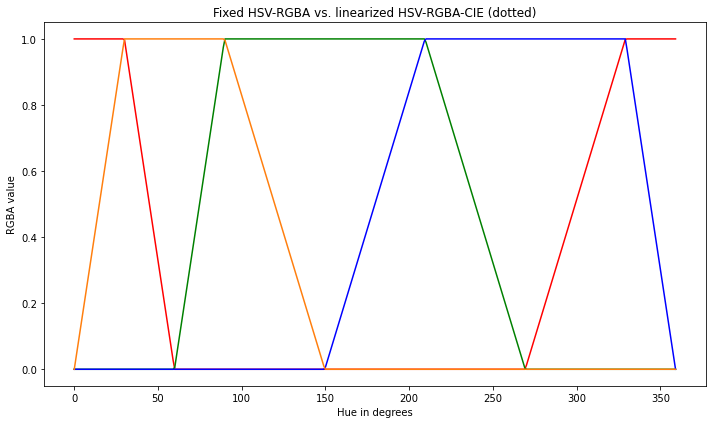

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 6.]
plt.rcParams["figure.autolayout"] = True
# Generate RGBA values for HSV spanning the hue range
importlib.reload(colorxform)
    #        print(blu_RGB)
cx = colorxform.ColorXform()

gamut_HSV = []
gamut_RGBA = []
gamut_RGBA_CIE = []
gamut_RGBA_CIE_warp = []

sat = 1.0
val = 1.0

# Use num =36 to compute regression & CIE plots, num=360 for plots!
#for hue in np.linspace(0., 1., num=36):
for hue in np.linspace(0., 1., num=360):
    gamut_HSV.append(np.array([hue, sat, val]))
    gamut_RGBA.append(np.array(cx.HSV_to_RGBA(hue, sat, val)))
    gamut_RGBA_CIE.append(np.array(cx.HSV_to_RGBA_CIE(hue, sat, val, warp = False)))
    gamut_RGBA_CIE_warp.append(np.array(cx.HSV_to_RGBA_CIE(hue, sat, val, warp = True)))

gamut_HSV = np.array(gamut_HSV)
gamut_RGBA = np.array(gamut_RGBA)
gamut_RGBA_CIE = np.array(gamut_RGBA_CIE)
gamut_RGBA_CIE_warp = np.array(gamut_RGBA_CIE_warp)

figure = plt.figure()
ax2 = figure.add_subplot()

ax2.plot(gamut_RGBA[:,0],'r')
ax2.plot(gamut_RGBA[:,1],'g')
ax2.plot(gamut_RGBA[:,2],'b')
ax2.plot(gamut_RGBA[:,3], color='tab:orange')


#ax2.plot(gamut_RGBA_CIE_warp[:,0],'r',linestyle='dotted')
#ax2.plot(gamut_RGBA_CIE_warp[:,1],'g',linestyle='dotted')
#ax2.plot(gamut_RGBA_CIE_warp[:,2],'b',linestyle='dotted')
#ax2.plot(gamut_RGBA_CIE_warp[:,3], color='tab:orange', linestyle='dotted')

plt.title("Fixed HSV-RGBA vs. linearized HSV-RGBA-CIE (dotted)")
plt.ylabel("RGBA value")
plt.xlabel("Hue in degrees")
figure.savefig("RGBA-HSV-CIE-nowarp.png")


<IPython.core.display.Javascript object>


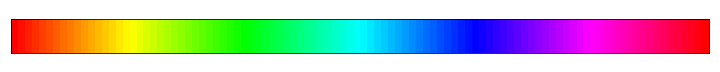

In [5]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [10, 1.]
plt.rcParams["figure.autolayout"] = True
figure, axes = colour.plotting.plot_multi_colour_swatches(gamut_RGB, width=1.0, height=5.0)

figure.savefig("swatch.png")

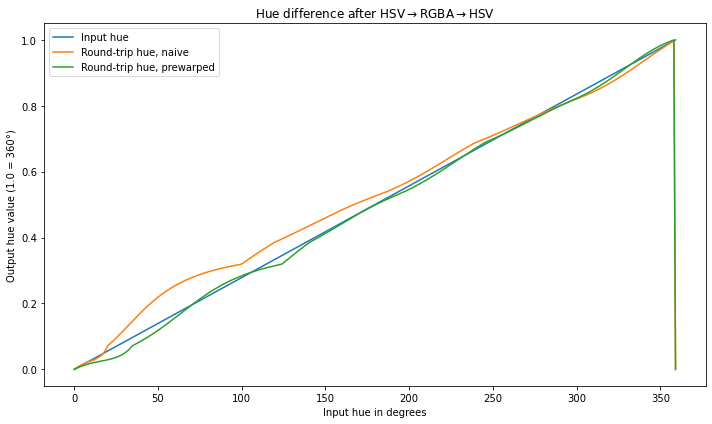

In [6]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10,6.]
# now convert RGBA back to HSV:
importlib.reload(colorxform)
    #        print(blu_RGB)
cx = colorxform.ColorXform()

# round-trip conversion back from original HSV, naive
HSV_RT = []
HSV_RT_warp = []
for RGBA in gamut_RGBA_CIE:
    H, S, V = cx.RGBA_to_HSV_CIE(RGBA[0], RGBA[1], RGBA[2], RGBA[3])
    HSV_RT.append(np.array([H, S, V]))

for RGBA in gamut_RGBA_CIE_warp:
    H, S, V = cx.RGBA_to_HSV_CIE(RGBA[0], RGBA[1], RGBA[2], RGBA[3])
    HSV_RT_warp.append(np.array([H, S, V]))

HSV_RT = np.array(HSV_RT)
HSV_RT_warp = np.array(HSV_RT_warp)

figure = plt.figure()
ax2 = figure.add_subplot()

ax2.plot(gamut_HSV[:,0],label='Input hue')
ax2.plot(HSV_RT[:,0], label='Round-trip hue, naive')
ax2.plot(HSV_RT_warp[:,0], label='Round-trip hue, prewarped')

plt.title("Hue difference after HSV$\\rightarrow$RGBA$\\rightarrow$HSV")
ax2.legend()
plt.ylabel(u"Output hue value (1.0 = 360\u00B0)")
plt.xlabel("Input hue in degrees")
colour.plotting.plot_multi_colour_swatches(gamut_RGB, width=1.0, height=2.0)
figure.savefig("HSV_vs_HSVRT-warp.png")

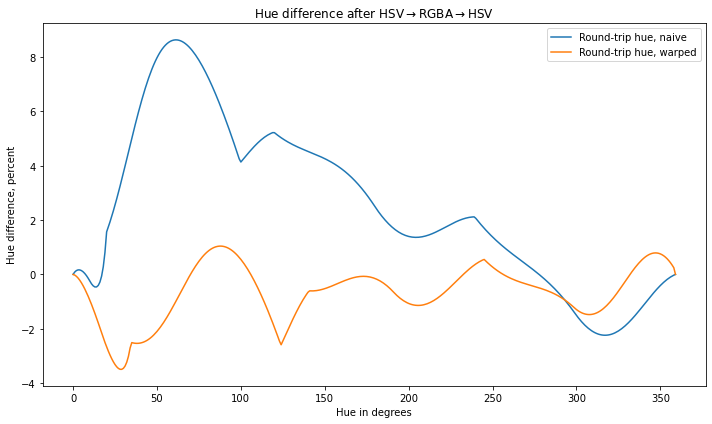

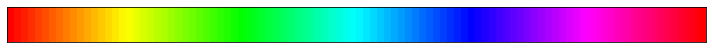

-0.00656510960597
-0.0349527979625 0.0104251263472


In [7]:
%matplotlib inline
plt.rcParams['text.usetex'] = False
plt.rcParams["figure.figsize"] = [10, 6.]
plt.rcParams["figure.autolayout"] = True

figure = plt.figure()
ax2 = figure.add_subplot()
diff_naive = np.array(HSV_RT[:,0] - gamut_HSV[:,0])
diff_naive[diff_naive < -0.5] += 1 
diff_naive[diff_naive > 0.5] -= 1 


diff_warp = np.array(HSV_RT_warp[:,0] - gamut_HSV[:,0])
diff_warp[diff_warp < -0.5] += 1 
diff_warp[diff_warp > 0.5] -= 1 


ax2.plot(100*diff_naive, label='Round-trip hue, naive')
ax2.plot(100*diff_warp, label='Round-trip hue, warped')


ax2.legend()
plt.title("Hue difference after HSV$\\rightarrow$RGBA$\\rightarrow$HSV")
plt.ylabel("Hue difference, percent")
plt.xlabel("Hue in degrees")
colour.plotting.plot_multi_colour_swatches(gamut_RGB, width=1.0, height=5.0)
figure.savefig("HSV_vs_HSVRT.png")

print(np.mean(diff_warp))
print(np.min(diff_warp),  np.max(diff_warp) )
figure.savefig("HSV_vs_HSVRT-difference.png")

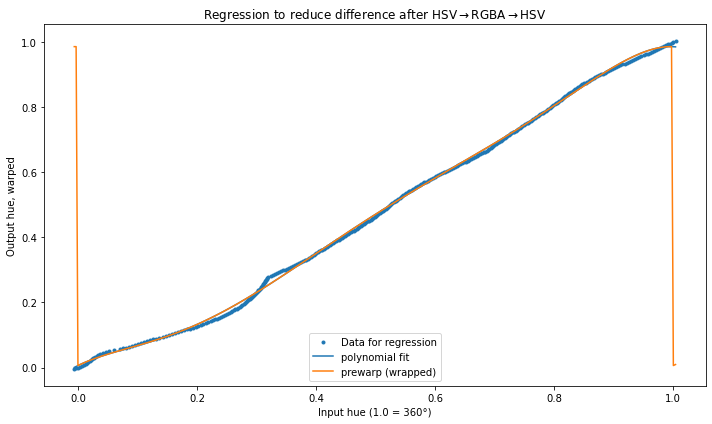

[  0.           0.88711799  -5.13990887  29.53893823 -61.89852135
  57.27126462 -19.68028923]


In [8]:
%matplotlib inline
%matplotlib inline
plt.rcParams['text.usetex'] = False
plt.rcParams["figure.figsize"] = [10, 6.]
plt.rcParams["figure.autolayout"] = True
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
importlib.reload(colorxform)
    #        print(blu_RGB)
cx = colorxform.ColorXform()

def polywarp(x, coeff=None):
    if coeff is None:
        coeff_w = [0.00577841,  0.68687651, -2.50694912, 17.56006685
                       -37.34857261, 34.06893111 -11.45908063]
    xn = 1
    res = 0.
    for c in coeff:
        res += c * xn
        xn = xn *x
    return(res)
    

#y = gamut_HSV[:-1, 0]
#x = HSV_RT[:-1,0]

y = gamut_HSV[:-1, 0]
x = HSV_RT[:-1,0]

# extend by n points on either end, 
# NOTE: REGRESSION IS COMPUTED FOR input N=36 points
n = 2
yex = np.append(y, y[0:n] + 1.0)
xex = np.append(x, x[0:n] + 1.0)

yex = np.append(y[-n:] -1.0, yex)
xex = np.append(x[-n:] -1.0, xex)


# extend y and X so fit and slope at ends are better
plt.scatter(xex, yex, marker='.', label='Data for regression')

# to fit x to y, 
# calculate polynomial coefficients 
poly2 = polyfit(xex, yex, 6)

# Calculate the polynomial fit for plotting
z = np.array([cx.prewarp(X, poly2) for X in xex])

# plot the fit and the unwrapped fit
plt.plot(xex, np.poly1d(poly2[::-1])(xex), label='polynomial fit')
plt.plot(xex, z, label = 'prewarp (wrapped)')

plt.title("Regression to reduce difference after HSV$\\rightarrow$RGBA$\\rightarrow$HSV")
plt.xlabel("Input hue (1.0 = 360\u00B0)")
plt.ylabel("Output hue, warped")
plt.legend()
plt.show()

figure.savefig("hue_regression.png")

# set coefficient 0 to 0.0 for no offset
poly2[0] = 0.0
with np.printoptions(suppress=True):
    print(poly2)
# result should be 
# [  0.           0.68687651  -2.50694912  17.56006685 -37.34857261
#   34.06893111 -11.45908063]

<IPython.core.display.Javascript object>


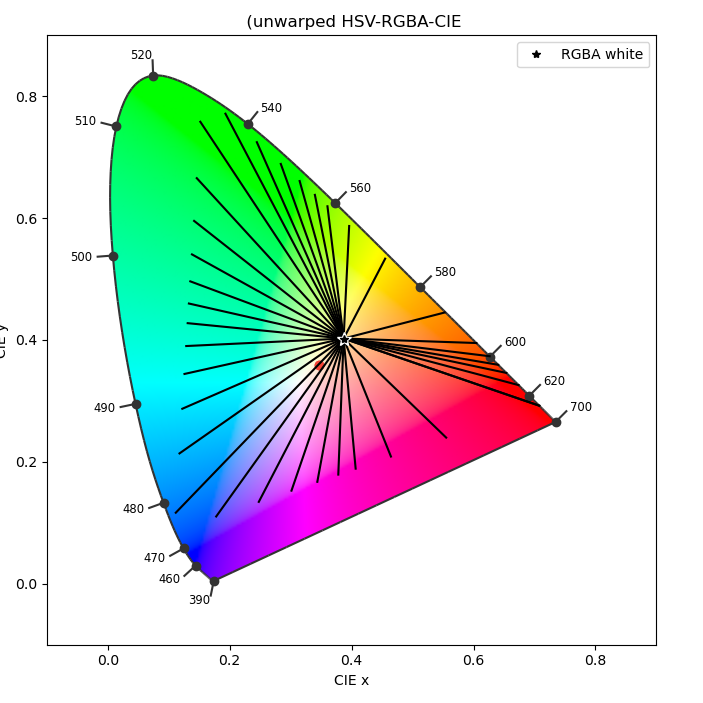

60


In [104]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True

importlib.reload(colorxform)
    #        print(blu_RGB)
cx = colorxform.ColorXform()


figure = plt.figure()
    
axes = figure.add_subplot()
#axes = figure.add_subplot(212)

plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
#    RGB = gamut_RGB,
    RGB = [],
    colourspace =  space,
    #colourspace = 'RGB_COLOURSPACE_BEST_RGB',
    axes = axes,
            #        colourspaces=["ACEScg"],
    colourspaces=[],
    scatter_kwargs={'c': 'k', 'marker': '+'},
    show_pointer_gamut = False,
    show_self_whitepoints = False,
    kwargs={'pointer_gamut_opacity': 0.0}

)
# get children now before we add anything so we can remove gamut later
ch = figure.get_children()
#print(ch)
ch = ch[1].get_children()

print(len(ch))
ch[46].remove()


#axes.plot([cx.white_xy[0], cx.red630_xy[0]], [cx.white_xy[1], cx.red630_xy[1]],  'k' )


gamut_xy = []

# for warped (use num=36 points or fewer)
#for rgba in gamut_RGBA_CIE:

# for unwarped (use num=36 points or fewer)
for rgba in gamut_RGBA:
    xy = cx.RGBA_to_xy(rgba[0], rgba[1], rgba[2], rgba[3])
    gamut_xy.append(xy)
    axes.plot([cx.LED_white_xy[0], xy[0]], [cx.LED_white_xy[1], xy[1]],  'k')

gamut_xy = np.array(gamut_xy)

axes.plot(cx.LED_white_xy[0], cx.LED_white_xy[1], 'w*',  markersize=10)
axes.plot(cx.LED_white_xy[0], cx.LED_white_xy[1], 'k*', label='RGBA white' )


# calculate white point for fully saturated gamut
#print(np.mean(gamut_xy[:,0]))    
#print(np.mean(gamut_xy[:,1]))    
    

plt.title(" (unwarped HSV-RGBA-CIE")
plt.legend()
plt.show()
#figure.canvas.draw()
#figure.show()
#xes.redraw_in_frame()
figure.savefig("CIE-gamut-unwarped.png")

<IPython.core.display.Javascript object>


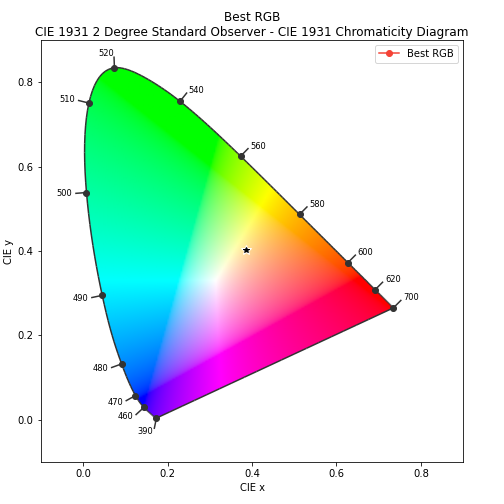

60


AttributeError: 'ColorXform' object has no attribute 'white_xy'

In [14]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True

importlib.reload(colorxform)
    #        print(blu_RGB)
cx = colorxform.ColorXform()


figure = plt.figure()
    
axes = figure.add_subplot()
#axes = figure.add_subplot(212)

plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
#    RGB = gamut_RGB,
    RGB = [],
    colourspace =  space,
    #colourspace = 'RGB_COLOURSPACE_BEST_RGB',
    axes = axes,
            #        colourspaces=["ACEScg"],
    colourspaces=[],
    scatter_kwargs={'c': 'k', 'marker': '+'},
    show_pointer_gamut = False,
    show_self_whitepoints = False,
    kwargs={'pointer_gamut_opacity': 0.0}

)
# get children now before we add anything so we can remove gamut later
ch = figure.get_children()
#print(ch)
ch = ch[1].get_children()

print(len(ch))
ch[46].remove()
ch[47].remove()
ch[47].remove()

axes.plot(cx.LED_white_xy[0], cx.LED_white_xy[1], 'w*',  markersize=10)
axes.plot(cx.LED_white_xy[0], cx.LED_white_xy[1], 'k*', label='RGBA white' )
axes.plot([cx.white_xy[0], cx.red630_xy[0]], [cx.white_xy[1], cx.red630_xy[1]],  'k', linestyle="dotted" )


gamut_xy = []

# for warped (use num=36 points or fewer)
#for rgba in gamut_RGBA_CIE:


plt.title("White to red primary vector")
plt.legend()
plt.show()
#figure.canvas.draw()
#figure.show()
#xes.redraw_in_frame()
figure.savefig("red_angle.png")

<IPython.core.display.Javascript object>


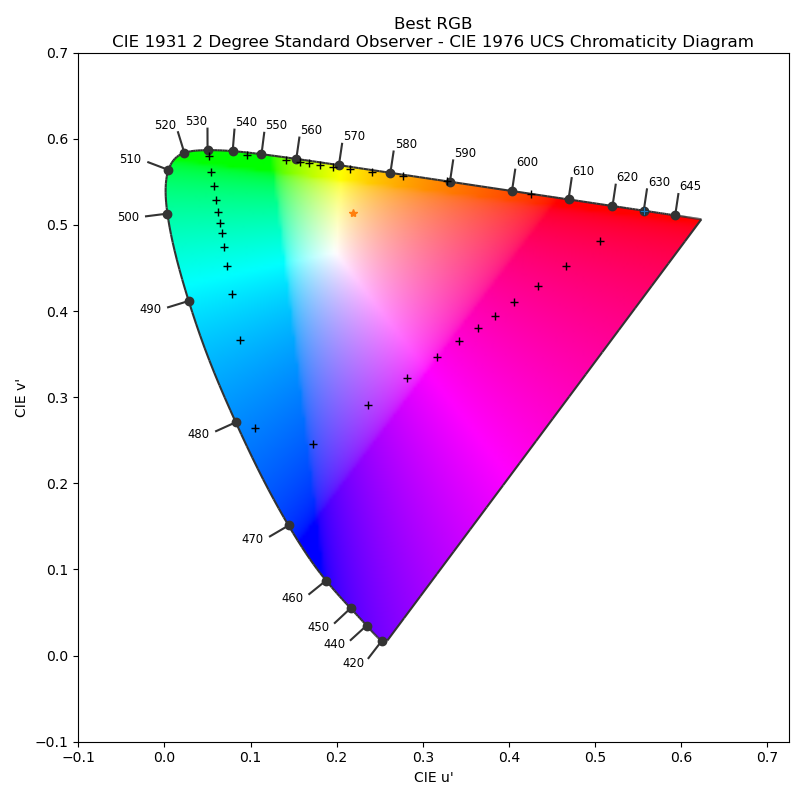

86
[ 0.21938762  0.51326637]
[ 0.55648558  0.51650767]


In [415]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [8, 8.]
plt.rcParams["figure.autolayout"] = True

space = 'Best RGB'
colourspace = colour.RGB_COLOURSPACES[space]

figure = plt.figure()
    
axes = figure.add_subplot()
#axes = figure.add_subplot(212)

plot_RGB_chromaticities_in_chromaticity_diagram_CIE1976UCS(
    RGB = [],
    #colourspace = "sRGB"
    colourspace = space,
    #colourspace = 'RGB_COLOURSPACE_BEST_RGB',
    axes = axes,
            #        colourspaces=["ACEScg"],
    colourspaces=[],
    scatter_kwargs={'c': 'k', 'marker': 'x'},
    show_pointer_gamut = False,
    show_whitepoints = False,
    kwargs={'pointer_gamut_opacity': 0.0}

)
# get children now before we add anything so we can remove gamut later
ch = figure.get_children()
#print(ch)
ch = ch[1].get_children()

print(len(ch))
for i in range(70,len(ch)):
    try:
        
        ch[i].remove()
    except:
        pass

sat_uv = []    
unsat_uv = []

for rgba in gamut_RGBA_CIE:

    xy_sat = cx.RGBA_to_xy_geom(rgba[0], rgba[1], rgba[2], rgba[3])
    uv_sat = colour.xy_to_Luv_uv(xy_sat)
    axes.plot(uv_sat[0], uv_sat[1], 'k+')

# #    axes.plot(xy_sat[0], xy_sat[1],  'k+' )
  

red630_uv = colour.xy_to_Luv_uv(cx.red630_xy)
#grn530_uv = gamut_uv[1]
#blu475_uv = gamut_uv[2]

axes.plot(red630_uv[0], red630_uv[1], '+')


white_uv = colour.xy_to_Luv_uv(cx.LED_white_xy)
axes.plot(white_uv[0], white_uv[1], '*')
print(white_uv)

print(red630_uv)
#print(blu475_uv)
# axes.plot([red630_uv[0], blu475_uv[0], grn530_uv[0], red630_uv[0]],
#           [red630_uv[1], blu475_uv[1], grn530_uv[1], red630_uv[1]],
#           'k' , linestyle='dotted')

#wht_uv = (red630_uv + blu475_uv + grn530_uv)/3.

#org_uv = gamut_uv[3]
#print(org_uv)
#axes.text(org_uv[0], org_uv[1], "orange LED")
#axes.text(wht_uv[0], wht_uv[1], "White")
#figure.canvas.draw()
#figure.show()
#axes.redraw_in_frame()
#plt.off()
figure.savefig("Luv-gamut-warped.png")